# INFO 2950 Phase 2: Group Project
__Group Members__: Adya Bhargava (ab2446), Akhil Damani (ad674), Madeline Demers (mkd79)


## Research Question
Can we calculate the probability that a player is selected MVP for a season based on their stats for the season? 

## Data Cleaning & Collection
Another file in the repository describes and contains the code for how we collected our data by scraping the NBA site, ESPN, and another site. In order to do this we had to find data that was legal to scrape and unlocked, which proved to be a difficult process. For example, the NBA site lets users access the player data, but not the team data. Furthermore, similar site also proved to be challenging in terms of accessing the data so to get the historical list of MVPs for the past 20 years, we ended up having to scrape a text article in order to get this data. Then, below we show the code and explanation for how we then cleaned this data (after saving them to .csv files). Please refer to the file titled 'data_colllection.ipynb' to see more detail about the in-depth data collection process we did.



In [2]:
import requests
from bs4 import BeautifulSoup

import pandas as pd
import duckdb
import numpy as np
import time
import matplotlib.pyplot as plt

**Player Stat Data Cleaning** 
In the 'data_collection.ipynb' file we were able to collect this data from the NBA stats site and then clean it up so as it met our needs. By reading the .csv file we had a large set of data that was of very good quality, documenting the past 20 seasons statistics for all of the players in the league during the regular season. Below, we dropped some unecessary columns that prove irrelevant to our analysis as well as rename some of the others to be more consistent with the headers across the board. A preview of the data frame is shown below.

In [3]:
player_stats_df = pd.read_csv('player_stats.csv')

player_stats_df = player_stats_df.drop("Unnamed: 0", axis=1)
player_stats_df = player_stats_df.drop("PLAYER_ID", axis=1)
player_stats_df = player_stats_df.drop("TEAM_ID", axis=1)
player_stats_df = player_stats_df.drop("RANK", axis=1)

player_stats_df.rename(columns={'Year': 'SEASON'}, inplace=True)

player_stats_df

,PLAYER,TEAM,GP,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,...,OREB,DREB,REB,AST,STL,BLK,TOV,PTS,EFF,SEASON
0,Tracy McGrady,ORL,67,39.9,9.7,23.4,0.417,2.6,7.7,0.339,...,1.4,4.6,6.0,5.5,1.4,0.6,2.7,28.0,23.7,2003-04
1,Peja Stojakovic,SAC,81,40.3,8.2,17.1,0.480,3.0,6.8,0.433,...,1.1,5.1,6.3,2.1,1.3,0.2,1.9,24.2,23.0,2003-04
2,Kevin Garnett,MIN,82,39.4,9.8,19.6,0.499,0.1,0.5,0.256,...,3.0,10.9,13.9,5.0,1.5,2.2,2.6,24.2,33.1,2003-04
3,Kobe Bryant,LAL,65,37.7,7.9,18.1,0.438,1.1,3.3,0.327,...,1.6,3.9,5.5,5.1,1.7,0.4,2.6,24.0,22.7,2003-04
4,Paul Pierce,BOS,80,38.8,7.5,18.7,0.402,1.4,4.8,0.299,...,0.9,5.7,6.5,5.1,1.6,0.7,3.8,23.0,20.5,2003-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4381,P.J. Tucker,PHI,75,25.6,1.3,3.0,0.427,0.7,1.9,0.393,...,1.3,2.7,3.9,0.8,0.5,0.2,0.6,3.5,6.6,2022-23
4382,Miles McBride,NYK,64,11.9,1.2,3.4,0.358,0.6,2.1,0.299,...,0.2,0.6,0.8,1.1,0.6,0.1,0.4,3.5,3.3,2022-23
4383,Anthony Gill,WAS,59,10.6,1.2,2.2,0.538,0.1,0.5,0.138,...,0.6,1.1,1.7,0.6,0.1,0.2,0.3,3.3,4.3,2022-23
4384,Christian Koloko,TOR,58,13.8,1.2,2.6,0.480,0.0,0.2,0.083,...,1.4,1.5,2.9,0.5,0.4,1.0,0.3,3.1,5.9,2022-23


In order to improve the process of merging, sorting, and analyzing our data we wanted to be sure that the abbreviations presented in the original file did not impede on our ability to merge with other dataframes we have such as the team statistics. So, we added a column mapping the full team name for each abbreviation. This also considered teams that have changed locations/names over the 20 year span in order to be inclusive of all relevant names and abbreviations in the data set. The column was also renamed and moved closer to the one it shares similarities with as for visual ease of use.

In [4]:
team_name_mapping = {
    'ORL': 'Orlando Magic',
    'SAC': 'Sacramento Kings',
    'MIN': 'Minnesota Timberwolves',
    'LAL': 'Los Angeles Lakers',
    'BOS': 'Boston Celtics',
    'NOH': 'New Orleans Hornets',
    'TOR': 'Toronto Raptors',
    'SAS': 'San Antonio Spurs',
    'DAL': 'Dallas Mavericks',
    'MIL': 'Milwaukee Bucks',
    'DEN': 'Denver Nuggets',
    'CLE': 'Cleveland Cavaliers',
    'LAC': 'LA Clippers',
    'NYK': 'New York Knicks',
    'IND': 'Indiana Pacers',
    'POR': 'Portland Trail Blazers',
    'PHX': 'Phoenix Suns',
    'GSW': 'Golden State Warriors',
    'NJN': 'New Jersey Nets',
    'ATL': 'Atlanta Hawks',
    'SEA': 'Seattle SuperSonics',
    'MEM': 'Memphis Grizzlies',
    'DET': 'Detroit Pistons',
    'HOU': 'Houston Rockets',
    'MIA': 'Miami Heat',
    'CHI': 'Chicago Bulls',
    'UTA': 'Utah Jazz',
    'PHI': 'Philadelphia 76ers',
    'WAS': 'Washington Wizards',
    'CHA': 'Charlotte Bobcats',
    'NOK': 'New Orleans/Oklahoma City Hornets',
    'OKC': 'Oklahoma City Thunder',
    'BKN': 'Brooklyn Nets',
    'NOP': 'New Orleans Pelicans'
}

player_stats_df['FULL_NAME'] = player_stats_df['TEAM'].map(team_name_mapping)
full_name_column = player_stats_df.pop("FULL_NAME")
player_stats_df.insert(player_stats_df.columns.get_loc("TEAM") + 1, "FULL_NAME", full_name_column)

player_stats_df

,PLAYER,TEAM,FULL_NAME,GP,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,...,OREB,DREB,REB,AST,STL,BLK,TOV,PTS,EFF,SEASON
0,Tracy McGrady,ORL,Orlando Magic,67,39.9,9.7,23.4,0.417,2.6,7.7,...,1.4,4.6,6.0,5.5,1.4,0.6,2.7,28.0,23.7,2003-04
1,Peja Stojakovic,SAC,Sacramento Kings,81,40.3,8.2,17.1,0.480,3.0,6.8,...,1.1,5.1,6.3,2.1,1.3,0.2,1.9,24.2,23.0,2003-04
2,Kevin Garnett,MIN,Minnesota Timberwolves,82,39.4,9.8,19.6,0.499,0.1,0.5,...,3.0,10.9,13.9,5.0,1.5,2.2,2.6,24.2,33.1,2003-04
3,Kobe Bryant,LAL,Los Angeles Lakers,65,37.7,7.9,18.1,0.438,1.1,3.3,...,1.6,3.9,5.5,5.1,1.7,0.4,2.6,24.0,22.7,2003-04
4,Paul Pierce,BOS,Boston Celtics,80,38.8,7.5,18.7,0.402,1.4,4.8,...,0.9,5.7,6.5,5.1,1.6,0.7,3.8,23.0,20.5,2003-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4381,P.J. Tucker,PHI,Philadelphia 76ers,75,25.6,1.3,3.0,0.427,0.7,1.9,...,1.3,2.7,3.9,0.8,0.5,0.2,0.6,3.5,6.6,2022-23
4382,Miles McBride,NYK,New York Knicks,64,11.9,1.2,3.4,0.358,0.6,2.1,...,0.2,0.6,0.8,1.1,0.6,0.1,0.4,3.5,3.3,2022-23
4383,Anthony Gill,WAS,Washington Wizards,59,10.6,1.2,2.2,0.538,0.1,0.5,...,0.6,1.1,1.7,0.6,0.1,0.2,0.3,3.3,4.3,2022-23
4384,Christian Koloko,TOR,Toronto Raptors,58,13.8,1.2,2.6,0.480,0.0,0.2,...,1.4,1.5,2.9,0.5,0.4,1.0,0.3,3.1,5.9,2022-23


The "SEASON" column was moved to provide an easier visual glance at the data upon looking at the large data frame in a form such as the one shown below. Then, this column was changed to a datetime object to ensure that in the future this will help us have well organized and formatted data.

In [5]:
season_column = player_stats_df.pop("SEASON")
player_stats_df.insert(player_stats_df.columns.get_loc("FULL_NAME") + 1, "SEASON", season_column)
player_stats_df

,PLAYER,TEAM,FULL_NAME,SEASON,GP,MIN,FGM,FGA,FG_PCT,FG3M,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PTS,EFF
0,Tracy McGrady,ORL,Orlando Magic,2003-04,67,39.9,9.7,23.4,0.417,2.6,...,0.796,1.4,4.6,6.0,5.5,1.4,0.6,2.7,28.0,23.7
1,Peja Stojakovic,SAC,Sacramento Kings,2003-04,81,40.3,8.2,17.1,0.480,3.0,...,0.927,1.1,5.1,6.3,2.1,1.3,0.2,1.9,24.2,23.0
2,Kevin Garnett,MIN,Minnesota Timberwolves,2003-04,82,39.4,9.8,19.6,0.499,0.1,...,0.791,3.0,10.9,13.9,5.0,1.5,2.2,2.6,24.2,33.1
3,Kobe Bryant,LAL,Los Angeles Lakers,2003-04,65,37.7,7.9,18.1,0.438,1.1,...,0.852,1.6,3.9,5.5,5.1,1.7,0.4,2.6,24.0,22.7
4,Paul Pierce,BOS,Boston Celtics,2003-04,80,38.8,7.5,18.7,0.402,1.4,...,0.819,0.9,5.7,6.5,5.1,1.6,0.7,3.8,23.0,20.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4381,P.J. Tucker,PHI,Philadelphia 76ers,2022-23,75,25.6,1.3,3.0,0.427,0.7,...,0.826,1.3,2.7,3.9,0.8,0.5,0.2,0.6,3.5,6.6
4382,Miles McBride,NYK,New York Knicks,2022-23,64,11.9,1.2,3.4,0.358,0.6,...,0.667,0.2,0.6,0.8,1.1,0.6,0.1,0.4,3.5,3.3
4383,Anthony Gill,WAS,Washington Wizards,2022-23,59,10.6,1.2,2.2,0.538,0.1,...,0.731,0.6,1.1,1.7,0.6,0.1,0.2,0.3,3.3,4.3
4384,Christian Koloko,TOR,Toronto Raptors,2022-23,58,13.8,1.2,2.6,0.480,0.0,...,0.627,1.4,1.5,2.9,0.5,0.4,1.0,0.3,3.1,5.9


**Team Stats Data Cleaning**
Once this data was collected and converted to a .csv file for each year, we looped through all of the years and collect the data into one main dataframe. we were able to rename columns to match the desired headers and ensure there were no string oddities, such as the '*' that had indicated a playoff team in the original site. We removed this so that it is consistent with the other data frame and then it will be easy to merge and compare the data properly. 

In [6]:
years = range(2003, 2023)

team_stats_dfs = []

for year in years:
    file_path = f'nba_team_stats/{year}.csv'
    
    team_stats_df = pd.read_csv(file_path)
    
    team_stats_df['Team'] = team_stats_df['Team'].str.replace('*', '')

    team_stats_df['Year'] = year

    year_end = str(year + 1)
    team_stats_df['Season'] = f'{year}-{year_end[2:4]}'
    
    team_stats_dfs.append(team_stats_df)

all_team_stats_df = pd.concat(team_stats_dfs, ignore_index=True)
all_team_stats_df = all_team_stats_df[all_team_stats_df['Team'] != 'League Average']

#Accounting for any name discrepancies
all_team_stats_df.loc[all_team_stats_df['Team'] == 'Los Angeles Clippers', "Team"] = 'LA Clippers'
all_team_stats_df.loc[all_team_stats_df['Team'] == 'Charlotte Hornets', "Team"] = 'Charlotte Bobcats'

all_team_stats_df = all_team_stats_df.drop("Year", axis=1)

all_team_stats_df



C:\Users\akhd2\AppData\Local\Temp\ipykernel_22036\3774699564.py:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  team_stats_df['Team'] = team_stats_df['Team'].str.replace('*', '')
C:\Users\akhd2\AppData\Local\Temp\ipykernel_22036\3774699564.py:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  team_stats_df['Team'] = team_stats_df['Team'].str.replace('*', '')
C:\Users\akhd2\AppData\Local\Temp\ipykernel_22036\3774699564.py:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  team_stats_df['Team'] = team_stats_df['Team'].str.

,Rk,Team,G,MP,FG,FGA,FG%,3P,3PA,3P%,...,AST,STL,BLK,TOV,PF,PTS,Age,W,L,Season
0,1.0,Dallas Mavericks,82,241.5,40.5,88.2,0.459,6.2,17.8,0.348,...,23.9,8.0,5.3,12.2,19.6,105.2,27.3,57.0,25.0,2003-04
1,2.0,Sacramento Kings,82,241.2,37.8,81.8,0.462,7.3,18.3,0.401,...,26.2,8.7,4.0,13.9,19.3,102.8,27.4,54.0,28.0,2003-04
2,3.0,Los Angeles Lakers,82,242.1,36.9,81.4,0.454,4.5,13.6,0.327,...,23.8,8.3,4.6,13.8,21.1,98.2,27.1,61.0,21.0,2003-04
3,4.0,Milwaukee Bucks,82,241.2,36.2,81.1,0.447,4.9,14.0,0.350,...,22.8,6.8,4.7,13.5,20.3,98.0,29.7,58.0,24.0,2003-04
4,5.0,Denver Nuggets,82,240.6,36.5,82.5,0.443,4.0,12.0,0.336,...,21.9,9.1,6.3,15.6,22.0,97.2,29.3,55.0,27.0,2003-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
613,26.0,Orlando Magic,82,241.2,40.5,86.3,0.470,10.8,31.1,0.346,...,23.2,7.4,4.7,15.1,20.1,111.4,25.1,33.0,49.0,2022-23
614,27.0,Charlotte Bobcats,82,241.8,41.3,90.4,0.457,10.7,32.5,0.330,...,25.1,7.7,5.2,14.2,20.3,111.0,25.3,27.0,55.0,2022-23
615,28.0,Houston Rockets,82,240.9,40.6,88.9,0.457,10.4,31.9,0.327,...,22.4,7.3,4.6,16.2,20.5,110.7,22.1,22.0,60.0,2022-23
616,29.0,Detroit Pistons,82,241.5,39.6,87.1,0.454,11.4,32.4,0.351,...,23.0,7.0,3.8,15.1,22.1,110.3,24.1,17.0,65.0,2022-23


**Cleaning Data about Historical MVPs**
This data is the list of MVPs for the seasons that we collected data on. This data was merged with the player_stats_df in order to match the player to their team to provide a better reference point. Columns were renamed as appropriate to develop a consistent header text across the data frames.

In [7]:

mvp_df = pd.read_csv('mvp_historical.csv')

mvp_team_df = duckdb.sql("""
SELECT mvp_df.Year, mvp_df.MVP_Name, player_stats_df.TEAM, player_stats_df.FULL_NAME, player_stats_df.PTS
FROM mvp_df
LEFT JOIN player_stats_df ON mvp_df.Year = player_stats_df.SEASON AND mvp_df.MVP_Name = player_stats_df.PLAYER
ORDER BY mvp_df.Year
""").df()

mvp_team_df.rename(columns={'Year': 'SEASON'}, inplace=True)
mvp_team_df.rename(columns={'MVP_Name': 'PLAYER'}, inplace=True)

mvp_team_df

,SEASON,PLAYER,TEAM,FULL_NAME,PTS
0,2003-04,Kevin Garnett,MIN,Minnesota Timberwolves,24.2
1,2004-05,Steve Nash,PHX,Phoenix Suns,15.5
2,2005-06,Steve Nash,PHX,Phoenix Suns,18.8
3,2006-07,Dirk Nowitzki,DAL,Dallas Mavericks,24.6
4,2007-08,Kobe Bryant,LAL,Los Angeles Lakers,28.3
5,2008-09,LeBron James,CLE,Cleveland Cavaliers,28.4
6,2009-10,LeBron James,CLE,Cleveland Cavaliers,29.7
7,2010-11,Derrick Rose,CHI,Chicago Bulls,25.0
8,2011-12,LeBron James,MIA,Miami Heat,27.1
9,2012-13,LeBron James,MIA,Miami Heat,26.8


**Merging Data About Players Rank Within Their Team**
TO DO: Once we have team data alongside player data, we can then merge these dfs and attempt to rank the players within their teams.
Describe process here


In [8]:

# #  Merge dataframes on 'SEASON' and 'FULL_NAME' columns
merged_df = duckdb.sql("SELECT * FROM player_stats_df p LEFT JOIN \
all_team_stats_df t ON p.FULL_NAME = t.TEAM AND p.SEASON = t.SEASON").df()

merged_df


,PLAYER,TEAM,FULL_NAME,SEASON,GP,MIN,FGM,FGA,FG_PCT,FG3M,...,AST_2,STL_2,BLK_2,TOV_2,PF,PTS_2,Age,W,L,Season
0,Tracy McGrady,ORL,Orlando Magic,2003-04,67,39.9,9.7,23.4,0.417,2.6,...,19.3,6.7,3.8,13.7,21.3,94.0,26.5,41.0,41.0,2003-04
1,Peja Stojakovic,SAC,Sacramento Kings,2003-04,81,40.3,8.2,17.1,0.480,3.0,...,26.2,8.7,4.0,13.9,19.3,102.8,27.4,54.0,28.0,2003-04
2,Kevin Garnett,MIN,Minnesota Timberwolves,2003-04,82,39.4,9.8,19.6,0.499,0.1,...,23.0,6.8,5.6,12.7,21.1,94.5,28.3,45.0,37.0,2003-04
3,Kobe Bryant,LAL,Los Angeles Lakers,2003-04,65,37.7,7.9,18.1,0.438,1.1,...,23.8,8.3,4.6,13.8,21.1,98.2,27.1,61.0,21.0,2003-04
4,Paul Pierce,BOS,Boston Celtics,2003-04,80,38.8,7.5,18.7,0.402,1.4,...,20.5,9.4,4.0,16.2,22.4,95.3,27.7,47.0,35.0,2003-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4381,Wenyen Gabriel,LAL,Los Angeles Lakers,2022-23,68,15.1,2.3,3.8,0.596,0.1,...,25.3,6.4,4.6,14.1,17.9,117.2,26.6,53.0,29.0,2022-23
4382,Derrick Jones Jr.,CHI,Chicago Bulls,2022-23,64,14.0,1.8,3.6,0.500,0.4,...,24.5,7.9,4.5,13.4,18.9,113.1,26.5,37.0,45.0,2022-23
4383,Vlatko Cancar,DEN,Denver Nuggets,2022-23,60,14.8,1.8,3.8,0.476,0.7,...,28.9,7.5,4.5,14.5,18.6,115.8,25.8,41.0,41.0,2022-23
4384,Christian Braun,DEN,Denver Nuggets,2022-23,76,15.5,1.9,3.8,0.495,0.4,...,28.9,7.5,4.5,14.5,18.6,115.8,25.8,41.0,41.0,2022-23


## Data Description

- __What are the observations (rows) and the attributes (columns)?__
- __Why was this dataset created?__
- __Who funded the creation of the dataset?__
- __What processes might have influenced what data was observed and recorded and what was not?__
- __What preprocessing was done, and how did the data come to be in the form that you are using?__
- __If people are involved, were they aware of the data collection and if so, what purpose did they expect the data to be used for?__
- __Where can your raw source data be found, if applicable? Provide a link to the raw data (hosted on Github, in a Cornell Google Drive or Cornell Box).__


## Data Limitations

The dataset scraped and built for the project encompasses a comprehensive collection of statistics and historical records spanning the past 20 seasons of the NBA including specifics about players and teams as well as the historical records of who received the MVP award for the past 20 seasons. It is a set that will be a resource for us when we aim to build a predictive model to estimate the probability of a player receiving the MVP award in future seasons. This dataset comprises various types of information, including individual player statistics, team statistics, and records of MVP winners, offering a multi-faceted view of the league's performance dynamics.

While this dataset has a lot of quality data that has been carefully collected and cleaned, it is not without its limitations. One notable challenge is data quality, where missing values and errors could potentially affect the integrity of the analyses. In the collection and cleaning process, we were sure to address this the best we could. Moreover, the data may be influenced by selection biases, as MVP awards can be influenced by non-statistical factors, such as media attention and player popularity. The dataset's relatively small sample size of MVPs compared to the total player population can present statistical challenges. Furthermore, it is essential to consider the evolving nature of the game, encompassing rule changes, shifts in playing style, and variations in MVP selection criteria, which the dataset might not fully encapsulate. There also is consideration not addressed for player injuries, retirements, team trades, and other insights that might be at play in the selection process. That being said, our data also covers the time during the pandemic when fewer games were played and the regular seasons were interrupted. Given the relatively small number of MVPs each season, there is a risk of overfitting the model to historical MVPs, making it less applicable for predicting future MVPs. Also, if player statistics are highly correlated, this can lead to multicollinearity issues when building predictive models. This can make it challenging to determine which individual statistics truly contribute to MVP selection. 

## Exploratory Data Analysis

In this plot, we compare the average points of players across the 2010-11 season with the average number of points for the MVP to visualize this comparison. 

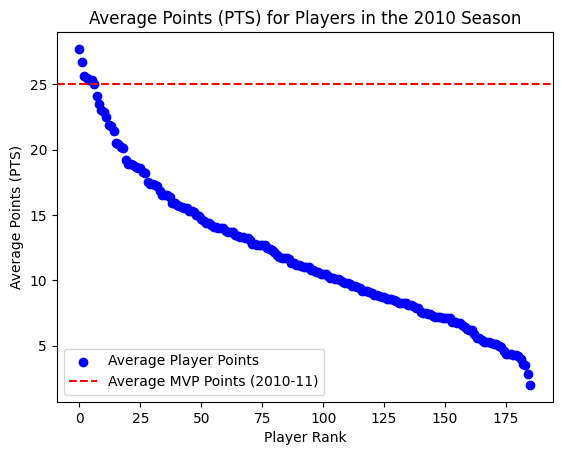

In [9]:
player_stats_2010 = player_stats_df[player_stats_df['SEASON'] == '2010-11']
mvp_stats_2010 = mvp_team_df[mvp_team_df['SEASON'] == '2010-11']

player_pts_2010 = player_stats_2010['PTS']

mvp_pts_2010 = mvp_stats_2010['PTS'].values[0]

plt.scatter(range(len(player_pts_2010)), player_pts_2010, label='Average Player Points', color='blue')
plt.axhline(y=mvp_pts_2010, color='red', linestyle='--', label='Average MVP Points (2010-11)')
plt.title('Average Points (PTS) for Players in the 2010 Season')
plt.xlabel('Player Rank')
plt.ylabel('Average Points (PTS)')
plt.legend()
plt.show()

This plot aims to display the average points for the MVP over 20 seasons.

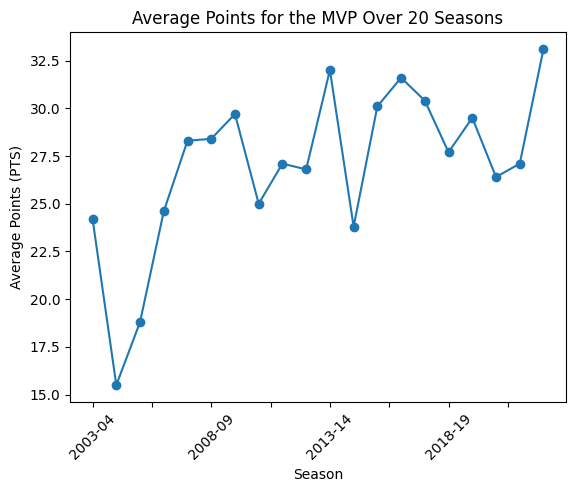

In [10]:
average_pts_mvp = mvp_team_df.groupby('SEASON')['PTS'].mean()

average_pts_mvp.plot(marker='o', linestyle='-')
plt.title('Average Points for the MVP Over 20 Seasons')
plt.xlabel('Season')
plt.ylabel('Average Points (PTS)')
plt.xticks(rotation=45)
plt.show()


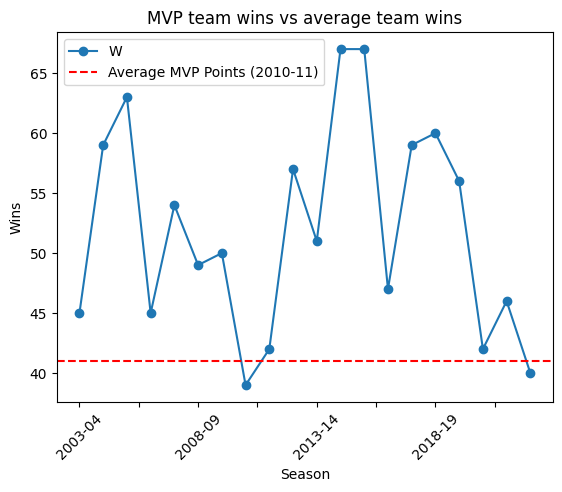

In [43]:
mvp_teams_df = duckdb.sql("SELECT * FROM mvp_team_df m LEFT JOIN \
    all_team_stats_df a ON m.FULL_NAME = a.TEAM AND m.SEASON = a.SEASON").df() 
mvp_average_wins = mvp_teams_df.groupby('Season')['W'].mean()

mvp_average_wins.plot(marker='o')
plt.title('MVP team wins vs average team wins')
#Always supposed to average out to 41 wins
plt.axhline(y=41, color='red', linestyle='--', label='Average Team Wins')
plt.xlabel('Season')
plt.xticks(rotation=45)
plt.ylabel('Wins')
plt.legend()
plt.show()




In [12]:
#Data Analysis

## Questions for Reviewers
1. Is our research question in depth enough for the scope of the project assignment? If not, how might you suggest we modify it to better reflect the project requirements?
2. TO DO
3. TO DO
